In [53]:
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx], idx


In [2]:
im5 = pyfits.open('merger_images/dusty_zoom1_total.fits')

wav = np.loadtxt('merger_images/waves_low.dat')

In [3]:
print(im5[0].header)

SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                  -32 / number of bits per data pixel                  NAXIS   =                    3 / number of data axes                            NAXIS1  =                  500 / length of data axis 1                          NAXIS2  =                  500 / length of data axis 2                          NAXIS3  =                  234 / length of data axis 3                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H BSCALE  =                   1.                                                  BZERO   =                   0.                                                  DATE    = '2019-02-15T05:10:21' / Date and time of creation (UTC)               ORIGIN  = 'SKIRT simulation'   / Astrono

Text(0, 0, '') [-100.    0.  100.  200.  300.  400.  500.]


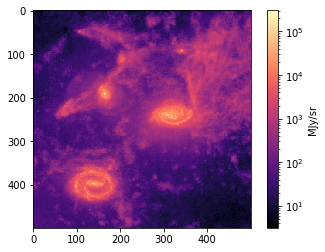

In [4]:

plt.clf()
imag = plt.imshow(np.sum(im5[0].data, axis=0), norm = matplotlib.colors.LogNorm(), cmap = 'magma')
plt.colorbar(imag, label = 'MJy/sr')
locs, labels = plt.xticks()
print(labels[1], locs)
#plt.xticklabels()
plt.show()
#45 kpc per side

(234, 500, 500) (235,)


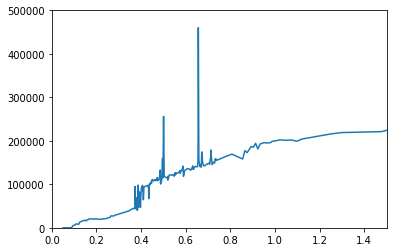

In [5]:
print(np.shape(im5[0].data), np.shape(wav))
SKIRT_spec = np.sum(im5[0].data, axis=(1,2))
plt.clf()
plt.plot(wav[1:], SKIRT_spec)
plt.xlim([0,1.5])
plt.ylim([0,5e5])
plt.show()

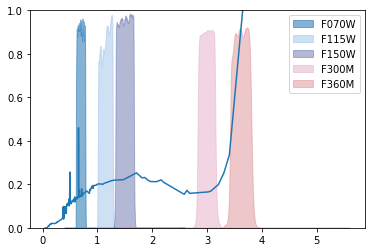

In [167]:


# Try to get individual filter curves
F070W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F070W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F115W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F115W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F140M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F140M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F150W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F150W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F150W = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F150W_filteronly_ModAB_mean.txt',
                  skiprows=1)
F300M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F300M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F360M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F360M_filteronly_ModAB_mean.txt',
                  skiprows=1)
F480M = np.loadtxt('nircam_throughputs/modAB_mean/filters_only/F480M_filteronly_ModAB_mean.txt',
                  skiprows=1)


#format is microns and throughput
plt.fill_between(F070W[:,0], 0, F070W[:,1], label='F070W', color='#0D69AB', alpha=0.5)

plt.fill_between(F115W[:,0], 0, F115W[:,1], label='F115W', color='#9FC3E9', alpha=0.5)
plt.fill_between(F150W[:,0], 0, F150W[:,1], label='F150W', color='#6874AC', alpha=0.5)
plt.fill_between(F300M[:,0], 0, F300M[:,1], label='F300M',color='#E4ADC8', alpha=0.5)
plt.fill_between(F360M[:,0], 0, F360M[:,1], label='F360M',color='#DC9095', alpha=0.5)

plt.plot(wav[1:], SKIRT_spec/1e6)
#plt.xlim([0,2])
plt.ylim([0,1])
plt.legend()
plt.show()

# Okay how do I select?
#np.convolve(SKIRT_spec)
from scipy import interpolate, fftpack



In [173]:
# Now how to translate this into an image?
# Oh ****, gotta do a multiplication in 3D 


def get_broadband(wav, cube, filter_jwst):
    # Input the cube and wavelength, cut into the area for each filter, 
    # and output the broadband image summed over those wavelengths
    print(np.shape(cube))
    broadband_img = np.zeros((np.shape(cube)[1], np.shape(cube)[2]))
    
    for i in range(np.shape(cube)[1]):
        for j in range(np.shape(cube)[2]):
            spec = cube[:,i,j]
            #SKIRT_spec = np.sum(im5[0].data, axis=(1,2))

            cut_index0 = find_nearest(wav,filter_jwst[:,0][0])[1]-3
            cut_index1 = find_nearest(wav,filter_jwst[:,0][-1])[1]+3
            int_func = interpolate.interp1d(wav[cut_index0:cut_index1], 
                                            spec[cut_index0:cut_index1])#wav[1:], SKIRT_spec)
            
            try:
                int_flux = int_func(filter_jwst[:,0])
                broadband_img[i,j] = np.sum(filter_jwst[:,1]*int_flux)
            except:
                nonzero = np.where(filter_jwst[:,1] > 0.01)
                nonzero_filter = filter_jwst[:,1][nonzero]
                nonzero_filter_x = filter_jwst[:,0][nonzero]
                
                
                
                if nonzero_filter_x[-1] > wav[-1]:
                    print('Filter not covered')
                    print('final wavelength of the filter', nonzero_filter_x[-1], 'final wav', wav[-1])
                    
                    plt.clf()
                    plt.plot(nonzero_filter_x, nonzero_filter)
                    plt.show()
                    
                    STOP
                    return broadband_img
                
                else:
                    int_flux = int_func(nonzero_filter_x)
                    broadband_img[i,j] = np.sum(nonzero_filter*int_flux)
            
            '''plt.clf()
            plt.plot(filter_jwst[:,0], filter_jwst[:,1]*int_flux, label='Interpolated Fluxes')
            plt.fill_between(filter_jwst[:,0], 0, filter_jwst[:,1], label='F150W', color='#6874AC', alpha=0.5)

            plt.legend()
            #plt.xlim([1.2,1.6])
            plt.show()'''
    return broadband_img
#F070W_img = get_broadband(wav[1:], im5[0].data, F070W)
#F115W_img = get_broadband(wav[1:], im5[0].data, F115W)
#F150W_img = get_broadband(wav[1:], im5[0].data, F150W)
F300M_img = get_broadband(wav[1:], im5[0].data, F300M)

F360M_img = get_broadband(wav[1:], im5[0].data, F360M)



(234, 500, 500)
(234, 500, 500)


(500, 500)
Text(0, 0, '') [-100.    0.  100.  200.  300.  400.  500.]


<Figure size 432x288 with 0 Axes>

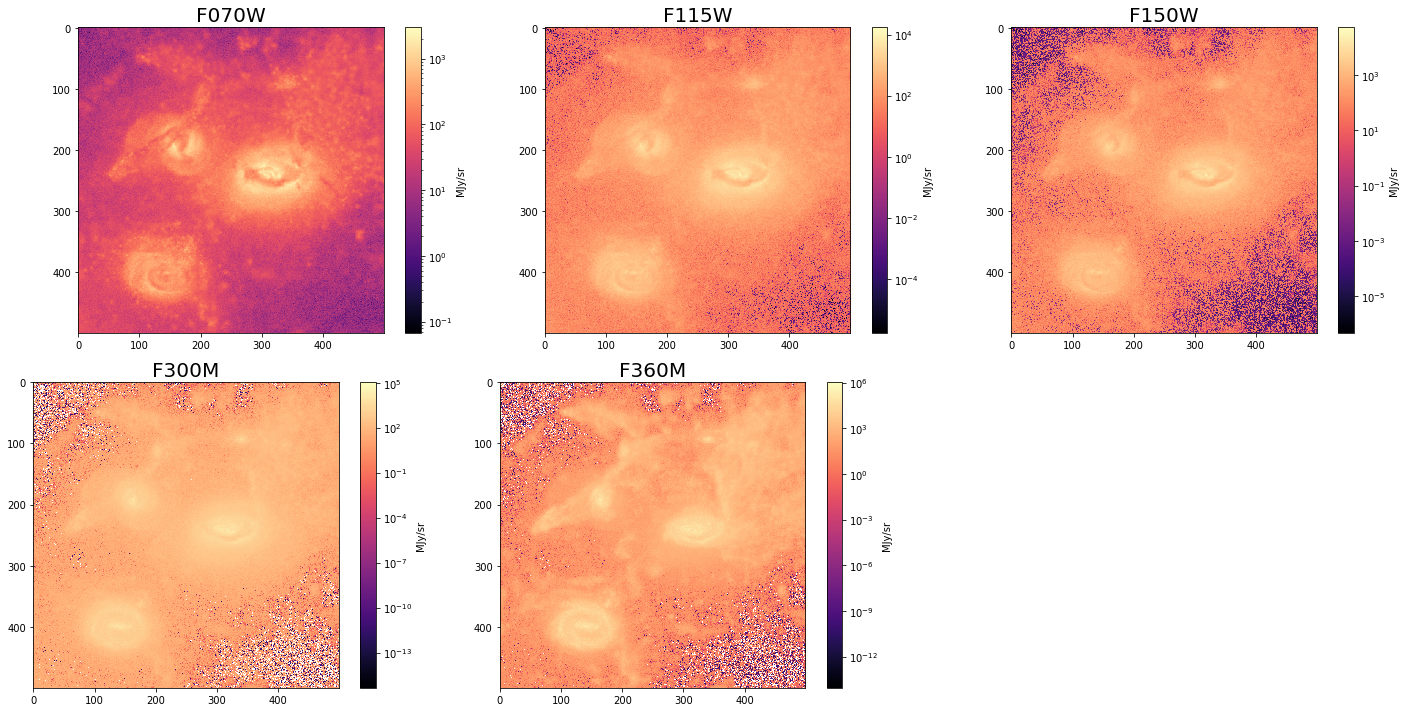

In [176]:
## Now you can make a beautiful image for all the different broadband filters :)
print(np.shape(F115W_img))

universal_cmap = 'magma'

plt.clf()
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(231)
im0 = ax0.imshow(F070W_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im0, label = 'MJy/sr', fraction = 0.046)
ax0.set_title('F070W', size=20)

ax1 = fig.add_subplot(232)
im1 = ax1.imshow(F115W_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im1, label = 'MJy/sr', fraction = 0.046)
ax1.set_title('F115W', size=20)

ax2 = fig.add_subplot(233)
im2 = ax2.imshow(F150W_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im2, label = 'MJy/sr', fraction = 0.046)
ax2.set_title('F150W', size=20)

ax3 = fig.add_subplot(234)
im3 = ax3.imshow(F300M_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im3, label = 'MJy/sr')
ax3.set_title('F300M', size=20)

ax4 = fig.add_subplot(235)
im4 = ax4.imshow(F360M_img,  norm = matplotlib.colors.LogNorm(), cmap = universal_cmap)
plt.colorbar(im4, label = 'MJy/sr')
ax4.set_title('F360M', size=20)

locs, labels = plt.xticks()
print(labels[1], locs)
#plt.xticklabels()
plt.tight_layout()
plt.show()
#45 kpc per side



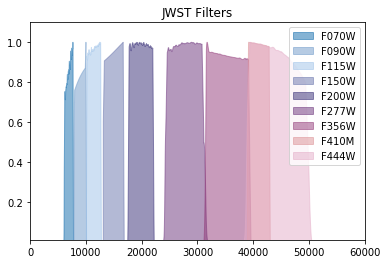

In [44]:
# So these are all Greg's filters:
# Which seem to be rougher than the official ones

F070W_g = np.loadtxt('greg_JWST_filters/nircam_f070w')
F090W_g = np.loadtxt('greg_JWST_filters/nircam_f090w')
F115W_g = np.loadtxt('greg_JWST_filters/nircam_f115w')
F150W_g = np.loadtxt('greg_JWST_filters/nircam_f150w')
F200W_g = np.loadtxt('greg_JWST_filters/nircam_f200w')
F277W_g = np.loadtxt('greg_JWST_filters/nircam_f277w')
F356W_g = np.loadtxt('greg_JWST_filters/nircam_f356w')
F444W_g = np.loadtxt('greg_JWST_filters/nircam_f444w')
F410M_g = np.loadtxt('greg_JWST_filters/nircam_F410M')


plt.clf()
plt.fill_between(F070W_g[:,0], 0, F070W_g[:,1], label='F070W', color='#0D69AB', alpha=0.5)
plt.fill_between(F090W_g[:,0], 0, F090W_g[:,1], label='F090W', color='#6E99C9', alpha=0.5)
plt.fill_between(F115W_g[:,0], 0, F115W_g[:,1], label='F115W', color='#9FC3E9', alpha=0.5)

plt.fill_between(F150W_g[:,0], 0, F150W_g[:,1], label='F150W', color='#6874AC', alpha=0.5)
plt.fill_between(F200W_g[:,0], 0, F200W_g[:,1], label='F200W', color='#342B75', alpha=0.5)

plt.fill_between(F277W_g[:,0], 0, F277W_g[:,1], label='F277W', color='#6B327B', alpha=0.5)
plt.fill_between(F356W_g[:,0], 0, F356W_g[:,1], label='F356W', color='#923978', alpha=0.5)

plt.fill_between(F410M_g[:,0], 0, F410M_g[:,1], color='#DC9095', alpha=0.5, label='F410M')

plt.fill_between(F444W_g[:,0], 0, F444W_g[:,1], label='F444W', color='#E4ADC8', alpha=0.5)


#plt.plot(F410M_g[:,0], F410M_g[:,1], label='F410M', color='#DC9095')


plt.xlim([0,60000])
plt.ylim([0.01,1.1])
plt.title(r'JWST Filters')
plt.legend()
plt.show()

In [63]:
# Try to get filter curves up and running:
#! /usr/bin/env/ python

'''plot the components of the optics file...for the TR'''

from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np

def replace_nan(items):
    for index, item in enumerate(items):
        if (item == '---'):
            items[index] = float('nan')
    return items


ofile = 'nircam_throughputs/optics/NIRCam_optics_transmission_29Oct2015.csv'

opttab = ascii.read(ofile,header_start=1,data_start=2,format='csv')


wave = opttab['Wavelength'].data.data
nvr_thru = opttab['NVR_Transmission'].data.data
nvr_wave = opttab['NVR_Wavelength'].data.data
collimator = opttab['Collimator'].data.data
sw_triplet = replace_nan(opttab['SW_Triplet'].data.data).astype('float')
sw_mirrors = replace_nan(opttab['SW_Mirrors'].data.data).astype('float')
lw_triplet = replace_nan(opttab['LW_triplet'].data.data).astype('float')
lw_mirrors = replace_nan(opttab['LW_Mirrors'].data.data).astype('float')
sw_particulates = replace_nan(opttab['SW_Particulates'].data.data).astype('float')
lw_particulates = replace_nan(opttab['LW_Particulates'].data.data).astype('float')

#remove extra entries in NVR columns
good = np.where(nvr_wave != 0.)[0]
nvr_thru = nvr_thru[good]
nvr_wave = nvr_wave[good]


#interpolate NVR to the same wavelength scale as the other columns
nvr_interp = np.interp(wave,nvr_wave,nvr_thru)

#combine the elements to produce a SW optics curve and a LW optics curve
#The 0.98 factor is a 'contingency factor' John Stansberry included in a 
#previous version. He said we can keep it out for this version
sw_optics = collimator * sw_triplet * sw_mirrors * sw_particulates #* 0.98
lw_optics = collimator * lw_triplet * lw_mirrors * lw_particulates #* 0.98


f,a = plt.subplots()
a.plot(wave,collimator,color='red',label='Collimator')

a.plot(wave,sw_triplet,color='blue',label='SW Triplet')
a.plot(wave,sw_mirrors,color='black',label='SW Mirrors')
a.plot(wave,sw_particulates,color='green',label='SW Particulates')

a.plot(wave,lw_triplet,color='blue',linestyle='--',label='LW Triplet')
a.plot(wave,lw_mirrors,color='black',linestyle='--',label='LW Mirrors')
a.plot(wave,lw_particulates,color='green',linestyle='--',label='LW Particulates')

a.plot(nvr_wave,nvr_thru,color='orange',label='NVR')

a.plot(wave,sw_optics,color='magenta',label='Total SW')
a.plot(wave,lw_optics,color='magenta',linestyle='--',label='Total LW')

a.set_xlim(0.5,5.5)
a.set_ylabel('Throughput')
a.set_xlabel('Wavelength (microns)')
a.legend(loc='lower right')

f.savefig('Optics_components_plot.pdf')
plt.close(f)
